In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

df=pd.read_csv("fil_data_movies_lessthan10k_removed.csv")

In [2]:
#added column for decade
df['decade'] = (pd.DatetimeIndex(df['release_date']).year // 10) * 10

df = df[df.decade != 1910]
df = df[df.decade != 1920]

df = df.drop(columns = ['title','backdrop_path','adult','release_date','homepage','imdb_id','original_title','overview','original_language','poster_path','tagline','production_companies','production_countries','spoken_languages'], axis = 1)
             
df

,id,vote_average,vote_count,revenue,runtime,budget,popularity,genres,decade
0,27205,8.364,34495,825532764,148,160000000,83.952,"Action, Science Fiction, Adventure",2010
1,157336,8.417,32571,701729206,169,165000000,140.241,"Adventure, Drama, Science Fiction",2010
2,155,8.512,30619,1004558444,152,185000000,130.643,"Drama, Action, Crime, Thriller",2000
3,19995,7.573,29815,2923706026,162,237000000,79.932,"Action, Adventure, Fantasy, Science Fiction",2000
4,24428,7.710,29166,1518815515,143,220000000,98.082,"Science Fiction, Action, Adventure",2010
...,...,...,...,...,...,...,...,...,...
7437,23618,6.180,50,38251106,115,13000000,5.937,"Comedy, Documentary",2000
7438,131978,5.800,50,3423685,92,2000000,4.786,Comedy,2010
7439,32858,5.980,50,1090000,69,75000,6.752,Horror,1940
7440,38617,5.670,50,7242035,102,12000000,4.880,"Action, Crime, Drama, Mystery, Thriller",1980


In [3]:
s = df['genres'].str.split(', ').explode()
encoder = OneHotEncoder()
encoded = encoder.fit_transform(s.values[:, None])
one_hot_df = pd.DataFrame(encoded.toarray(), columns=np.ravel(encoder.categories_), dtype='int') \
                .groupby(s.index) \
                .sum()

final = pd.concat([df, one_hot_df], axis=1)

In [4]:
#top 10 movie genres of all time
genre_counts = final.iloc[:, 9:].sum()
genre_percents = (genre_counts / len(df)) * 100
genre_percents=genre_percents.sort_values(ascending=False)
genre_percents[:10]

#percents_list=genre_percents.tolist()


Drama              45.683502
Comedy             36.767677
Thriller           25.737374
Action             25.481481
Adventure          18.343434
Romance            18.101010
Crime              16.013468
Horror             11.851852
Science Fiction    11.434343
Family             10.491582
dtype: float64

In [5]:
#average runtime per decade

runtime = final.groupby('decade')['runtime']
runtime.mean() #filmid tegelt ei ole ajaga pikemaks läinud
#runtime.count() #filme kümnenditest 1910,1920 on liiga vähe et mingit arvamust luua

decade
1930    102.312500
1940    105.777778
1950    113.702703
1960    128.098039
1970    112.375000
1980    106.264664
1990    109.436596
2000    108.185060
2010    110.131372
2020    114.210900
Name: runtime, dtype: float64

In [6]:
#average score per year

votes = final.groupby('decade')['vote_average']
votes.mean() #vanemad filmid veits kõrgema ratinguga, samas kui sa hakkad 80a vana filmi vaatama ss see pole mingi random

decade
1930    7.086583
1940    7.156235
1950    7.017297
1960    7.061458
1970    6.775956
1980    6.474004
1990    6.433739
2000    6.349668
2010    6.489110
2020    6.873121
Name: vote_average, dtype: float64

In [7]:
#top10 genres
genres = ("Drama","Comedy","Thriller","Action","Adventure","Romance","Crime","Horror","Science Fiction","Family")


total_movies_by_decade = final.groupby('decade')['id'].count()


genres_by_decade_count = final.groupby('decade')[['id']].count()
for genre in genres:
    genre_movie_by_decade = final.groupby('decade')[genre].sum()
    genre_percent_by_decade = (genre_movie_by_decade / total_movies_by_decade)*100
    genres_by_decade_count[genre] = genre_percent_by_decade

genres_by_decade_count = genres_by_decade_count.drop('id', axis=1)

#get top3 trending genres by movie production, the genres which are not in "genres" list do not change the result.
t1 = genres_by_decade_count.columns[genres_by_decade_count.values.argsort(1)[:, -1]]
t2 = genres_by_decade_count.columns[genres_by_decade_count.values.argsort(1)[:, -2]]
t3 = genres_by_decade_count.columns[genres_by_decade_count.values.argsort(1)[:, -3]]

genres_by_decade_count['top1'] = t1
genres_by_decade_count['top2'] = t2
genres_by_decade_count['top3'] = t3

genres_by_decade_count

top_genres_by_decade = genres_by_decade_count.drop(
    columns=['Drama', 'Comedy','Thriller', 'Action','Adventure', 'Romance','Crime', 'Horror','Science Fiction', 'Family'])

top_genres_by_decade

,top1,top2,top3
decade,,,
1930,Drama,Comedy,Romance
1940,Drama,Romance,Thriller
1950,Drama,Romance,Comedy
1960,Drama,Comedy,Romance
1970,Drama,Comedy,Thriller
1980,Comedy,Drama,Action
1990,Drama,Comedy,Thriller
2000,Drama,Comedy,Thriller
2010,Drama,Comedy,Action


In [8]:
#get mean revenue and budget by decade
average_revenue_by_decade = final.groupby('decade')['revenue'].mean()
average_budget_by_decade = final.groupby('decade')['budget'].mean()

#calculate average profit
profit_avg = pd.merge(average_revenue_by_decade,average_budget_by_decade, right_index = True, left_index = True)
#profit as relation of revenue against budget in decimal
profit_avg['profit%'] = profit_avg['revenue'] / profit_avg['budget']

profit_avg=profit_avg.drop("revenue",axis=1)
profit_avg=profit_avg.drop("budget",axis=1)

In [9]:
#get average profit per decade per genre
for genre in genres:
    new_df = final[final[genre] == 1]
    new_df.groupby('decade')['budget'].mean()
    profit_avg[genre] = new_df.groupby('decade')['revenue'].mean() / new_df.groupby('decade')['budget'].mean()
    
profit_avg

,profit%,Drama,Comedy,Thriller,Action,Adventure,Romance,Crime,Horror,Science Fiction,Family
decade,,,,,,,,,,,
1930,15.355306,17.369044,3.307387,NaN,1.842626,4.521738,19.749165,3.911450,9.719275,12.543554,41.537445
1940,5.308787,7.773285,2.831614,3.245799,1.941521,2.445078,3.665507,3.012938,7.221401,NaN,31.704097
1950,5.390446,5.876334,3.563355,4.589618,6.605995,6.803117,4.522262,3.126262,7.736475,5.264777,8.762790
1960,4.935319,4.658794,4.721685,9.892212,8.329482,6.324294,4.846268,4.961484,12.189251,3.192510,13.823141
1970,8.102907,6.811010,8.574119,7.831590,8.604326,7.817014,8.874082,8.915396,15.932340,8.870569,3.666110
1980,3.638584,3.285145,3.923475,3.160891,3.965161,4.077602,3.975081,3.403885,2.722682,3.629635,4.287272
1990,2.579179,2.526571,2.659451,2.357766,2.413476,2.916675,3.294630,2.238297,2.048833,2.466177,2.951648
2000,2.521045,2.193164,2.519548,2.175265,2.481741,2.832641,2.609871,2.096103,2.451765,2.379890,2.709272
2010,3.212113,2.766315,3.340044,3.006896,3.169263,3.516933,3.236043,2.683411,4.407586,3.455140,3.423917


In [10]:
top_genres_by_decade = genres_by_decade_count.drop(
    columns=['Drama', 'Comedy','Thriller', 'Action','Adventure', 'Romance','Crime', 'Horror','Science Fiction', 'Family'])

top_genres_by_decade

,top1,top2,top3
decade,,,
1930,Drama,Comedy,Romance
1940,Drama,Romance,Thriller
1950,Drama,Romance,Comedy
1960,Drama,Comedy,Romance
1970,Drama,Comedy,Thriller
1980,Comedy,Drama,Action
1990,Drama,Comedy,Thriller
2000,Drama,Comedy,Thriller
2010,Drama,Comedy,Action


In [11]:
B = top_genres_by_decade
profitpercentage=top_genres_by_decade



for topN in B.columns:
    dic = {1930:[],
        1940:[],
        1950:[],
        1960:[],
        1970:[],
        1980:[],
        1990:[],
        2000:[],
        2010:[],
        2020:[]}
    
    for decade in top_genres_by_decade.index:
        genre = top_genres_by_decade.loc[decade,topN]
        profit = (profit_avg.loc[decade, genre] - profit_avg.loc[decade, 'profit%']).round(4)
        #print(profit)
        dic[decade] = profit
    profitpercentage[topN+'profit'] = dic

profitpercentage

,top1,top2,top3,top1profit,top2profit,top3profit
decade,,,,,,
1930,Drama,Comedy,Romance,2.0137,-12.0479,4.3939
1940,Drama,Romance,Thriller,2.4645,-1.6433,-2.0630
1950,Drama,Romance,Comedy,0.4859,-0.8682,-1.8271
1960,Drama,Comedy,Romance,-0.2765,-0.2136,-0.0891
1970,Drama,Comedy,Thriller,-1.2919,0.4712,-0.2713
1980,Comedy,Drama,Action,0.2849,-0.3534,0.3266
1990,Drama,Comedy,Thriller,-0.0526,0.0803,-0.2214
2000,Drama,Comedy,Thriller,-0.3279,-0.0015,-0.3458
2010,Drama,Comedy,Action,-0.4458,0.1279,-0.0428


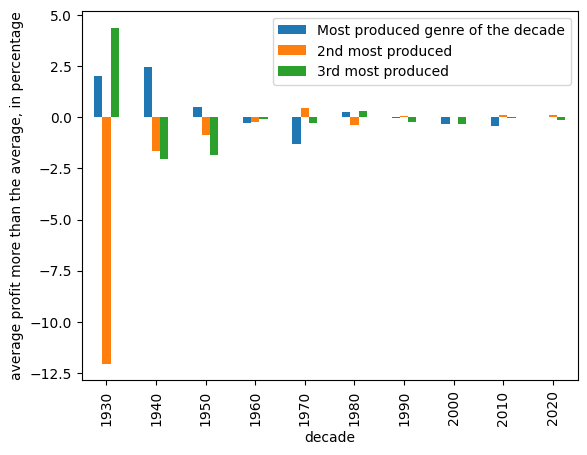

In [12]:
plot = profitpercentage.plot(kind = 'bar')
plot.set_ylabel('average profit more than the average, in percentage')
plt.gca().legend(('Most produced genre of the decade','2nd most produced','3rd most produced'))
plt.show()